## Libraries/Packages

In [58]:
!open .

In [235]:
# ! pip install numpy scipy sympy pandas matplotlib plotly tqdm tqdm-joblib ipywidgets
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

# ! pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu # install pre-release (nightly) with MPS support
# or
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# ! pip install torchdiffeq
# ! pip install -U pysindy
# ! pip install PyWavelets # for pywt
# ! pip install scikit-image
# ! pip install statsmodels
# (!pip install torchvista)

# Data-driven identification of biomedical systems using multi-scale analysis

I. Muhammed, D.M. Manias, D.A. Goussis, H. Hatzikirou.<br> 
Mathematics Department<br> 
Khalifa University of Science and Technology<br> 
V1.0.0, 04-06-2025<br>

****

<details>
<summary>
<font>
<b>Model Details </b>
</font>
</summary>
Michaelis-Menten Model
    
y variables represent the concetrations of:<br> 
<code>y1 : c</code> (complex), 
<code>y2 : s</code> (substrate) , 

**Parameters**<br> 

<code>k1f</code> : formation rate constant of the enzyme-subtrate complex<br> 
<code>k1b</code> : dissociation rate constant of the enzyme-subtrate complex<br> 
<code>k2</code> : catalysis rate constant<br> 
<code>E0</code> : total enzyme concentration

**Mathematical Model**<br> 
 
<code>g(y) = g/c\ = / k1f.(E0 - y2).y1  - k1b.y2 - k2.y2 \  =  / R1f - R1b -R2 \ = /  1,  -1 \  / R1 \   (R1 = R1f - R1b) .
         \s/   \ -k1f.(E0 - y2).y1  + k1b.y2        /     \ -R1f +R1b     /   \ -1,  0  /  \ R2 /                    .</code>
     

</details>


# Libraries & Flags

In [1]:
import sys
sys.dont_write_bytecode = True
import os
import shutil
import numpy as np
import scipy as sp
import sympy as smp 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint


# rename the module names to default names for code consistency 
# shutil.copy('model_module_PEA.py', 'model_module.py') 
# shutil.copy('v_0.4.5_CSPmodule.py', 'CSP_module.py') 
import model_module as model             # Load Model and Model Parameters from model_module.py
import CSP_module as csp                  # Load CSP tools from CSPmodule.py
%load_ext autoreload

global nspec, kreac
nspec = model.nSpec                      # number of variables/species (set in model_module)
kreac = model.kReac                      # number of reactions         (set in model_module)
vars  = model.var_names()                # Species names

model.init_symbolic_model(nspec, kreac); # Initialize module functions for RHS separation


# paths-format options
results_path     = 'results'             # name of the results folder
text_format      = 'txt'                 # text format of the data file
figs             = 'figs'                # name of the figures folder
figs_format      = 'pdf'                 # figure format
time_unit        = 's'                   # time unit for figures

# Calculation flags
full_solution    = True                 # Calculate solution using the full model
noise            = False                 # adds noise to calculated solution
parallel_calc    = True                  # runs numerical RHS and CSP calculations in parallel
NODE             = True                  # uses NODE for RHS calculation
ANN              = True                  # uses Neural Network for Jacobian estimation

#Solution flags
write_data       = True
plot_solution    = True
plot_phase       = False
plot_rates       = True

#CSP flags
write_diagn      = False
plot_timescales  = True
plot_amplitudes  = True
plot_Po          = True

# for typos...
false = False
true  = True

In [2]:
autoreload 2

# Model Solution

In [3]:
global vars, figs, text_format
t0 = 0                                # initial time (s)
tf = 20                               # total simulation time (s)
dt = 0.05                              # time step
t_points = int(tf/dt)                 # solution datapoints

# Preallocation -----------------------------------------------------------
t = np.linspace(t0, tf, t_points)
y = np.zeros((nspec + 1, t_points))   # variables vector y[i] = yi
t_span = [t0, tf]                     # Time span for simulation

# Initial Conditions [c0, s0] --------------------------------------------
c0 = 9.999999
s0 = 10
y0 = [c0, s0]

# Solution of the model --------------------------------------------------
if full_solution:
    # Full model
    solution = solve_ivp(fun=model.system_of_eqs,t_span=t_span,y0=y0,t_eval=t,method='RK45',atol=1e-18,rtol=1e-12)
else:
    # PEA model
    solution = solve_ivp(fun=model.slow_system_of_eqs_PEA,t_span=t_span,y0=y0,t_eval=t,method='RK45',atol=1e-18,rtol=1e-12)

y[1:]=solution.y

if write_data: model.write_solution(t,y, nspec, results_path, text_format)
print(f'A solution was generated of {t_points} points')

A solution was generated of 400 points


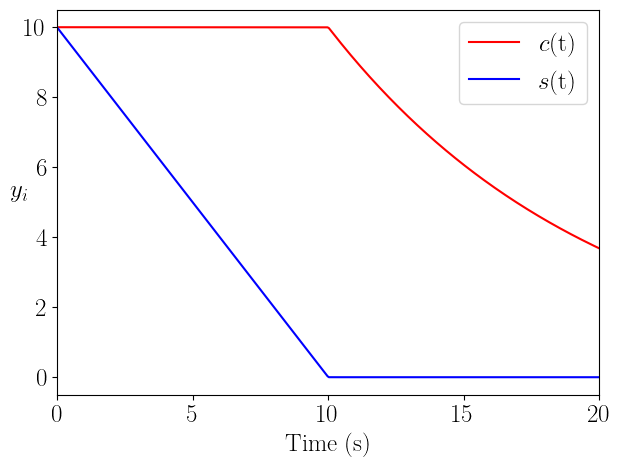

In [5]:
# Plotting. Set interactive=True for interactive graphs and analysis
plot_phase = False
if plot_phase: model.plot_phase(y, figs, figs_format, vars, pos = [1,2], nskip=1, interactive =False)

if plot_solution: model.plot_solution(t, y, nspec, figs, figs_format, vars, time_unit,
                                      xlim=[t0,tf], ylim=[None,None],log=False, interactive=False)


# CSP Diagnostics for the explicit model

## Calc timescales, amplitudes and Pointer for the explicit model

In [7]:
model.init_symbolic_model(nspec,kreac)

parallel_calc = False
[Rates, ALPHAs, BETTAs, eigens, timescales, exp_timescales, amplitudes, TPIs, APIs, Pointer, IIs
] = csp.diagn_parallel(nspec, kreac, y, API_changed_sign=False, n_jobs=-1) if parallel_calc else csp.diagn(nspec, kreac, y, API_changed_sign=False)

♾️ CSP analysis: 100%|████████████████████████████████████████████████████ 00:00


### Save diagnostics

In [8]:
if write_diagn:
    csp.write_rates(t, Rates, kreac, results_path, text_format)
    csp.write_eigens(t, eigens, nspec, results_path, text_format)
    csp.write_timescales(t, timescales, nspec, results_path, text_format)
    csp.write_amplitudes(t, amplitudes, nspec, results_path, text_format)
    csp.write_pointers(t, Pointer, nspec, results_path, text_format)

### Plots

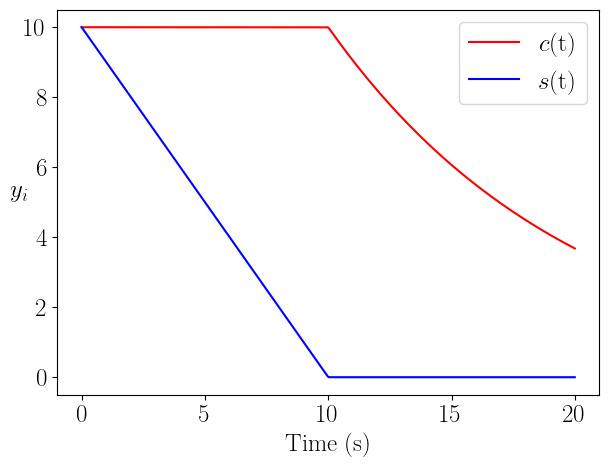

In [9]:
if plot_solution: model.plot_solution(t, y, nspec, figs, figs_format, vars, time_unit,
                                      xlim=[None,None], ylim=[None,None],log=False, interactive=false)

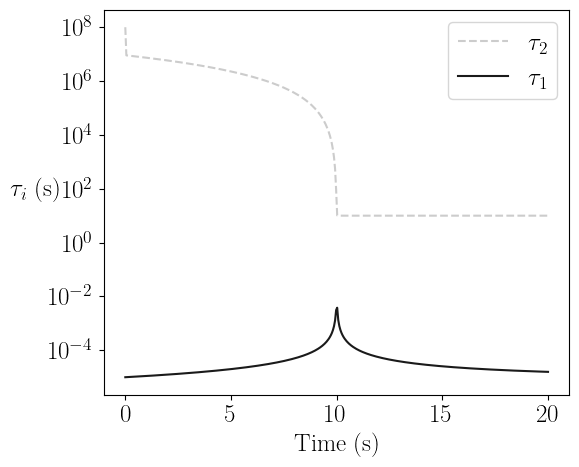

In [14]:
if plot_timescales: csp.plot_timescales(t, timescales, exp_timescales, nspec, figs, figs_format, time_unit, 
                                        xlim=[None,None], ylim=[None,None], nfast=1, log=[False, True], interactive=false);

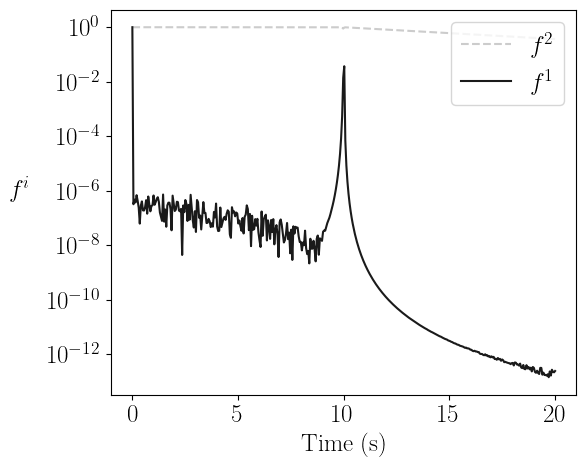

In [16]:
if plot_amplitudes: csp.plot_amplitudes(t, amplitudes, nspec, figs, figs_format, time_unit,
                                        xlim=[None,None], ylim=[None,None], nfast=1, log=[False, True], interactive=False);

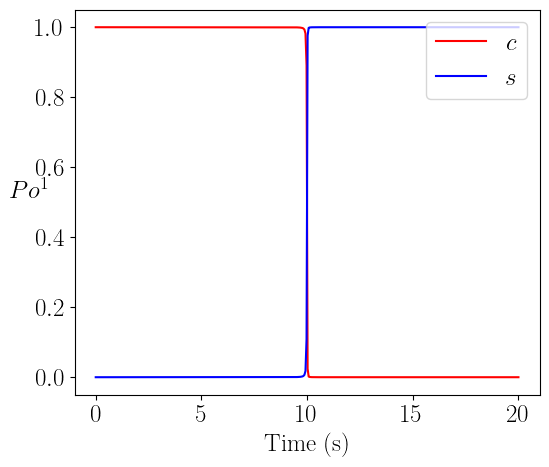

In [17]:
if plot_Po: csp.plot_Po(t, Pointer, nspec, vars, figs, figs_format, time_unit, 
                        xlim=[None,None], ylim=[None,None], mode=1, interactive=False)

# SINDy on original Full Dataset

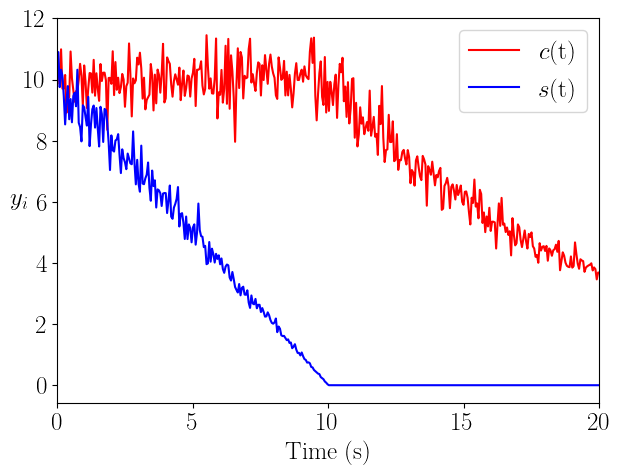

In [18]:
# Read the solution
file_path = os.path.join(results_path, f"sol.{text_format}")
t, data = model.read_solution(file_path, nspec=nspec)

# Add noise ---------------------------------------------------------------
noise = True
if noise:
    np.random.seed(42)
    data = model.add_noise(data, noise_type = 'multiplicative', percentage = 1) # noise_type = 'additive' or 'multiplicative'

x = data.copy()
if plot_solution: model.plot_solution(t, x[:, [0, 0, 1]].T, nspec, figs, figs_format, vars, time_unit,
                                      xlim=[t0,tf], ylim=[None,None],log=False, interactive=False)


In [46]:
import WeakSINDy_module as sindy
np.random.seed(42)
results = sindy.run_weak_sindy(t, x, noise, thresholds=[0.001, 0.005, 0.01, 0.02], vars=vars)

Threshold = 0.001
Dynamic model:
(c)' = -0.171 c + -0.109 s + 0.011 c^2 + -0.023 s^2 + 0.038 cs
(s)' = 0.069 c + -1.139 s + -0.011 c^2 + 0.031 s^2 + 0.084 cs
R² score: 0.73676

Threshold = 0.005
Dynamic model:
(c)' = -0.171 c + -0.109 s + 0.011 c^2 + -0.023 s^2 + 0.038 cs
(s)' = 0.069 c + -1.139 s + -0.011 c^2 + 0.031 s^2 + 0.084 cs
R² score: 0.73676

Threshold = 0.01
Dynamic model:
(c)' = -0.171 c + -0.109 s + 0.011 c^2 + -0.023 s^2 + 0.038 cs
(s)' = 0.069 c + -1.139 s + -0.011 c^2 + 0.031 s^2 + 0.084 cs
R² score: 0.73676

Threshold = 0.02
Dynamic model:
(c)' = -0.084 c + -0.587 s + -0.032 s^2 + 0.095 cs
(s)' = -0.471 s + 0.046 s^2
R² score: 0.66626



# NODE

In [47]:
if NODE:
    from NODE_module import ODEFunc, train_node, compute_derivatives
    
    # Build the NODE model
    node_model = ODEFunc(nspec=nspec, hidden_dims=[64, 128, 128, 64])
    
    # Train the model
    y_pred = train_node(node_model, t = t, y0 = x[0], y_true = x, 
                        epochs = 2000, early_stop_patience=None,
                        lr = 1e-3, rtol = 1e-6, atol = 1e-6, verbose = True)
    
    # Compute the derivatives along the learned trajectory
    derivs = compute_derivatives(node_model, y_pred)  # shape (T,nspec)

                                                                                0 1:11:53

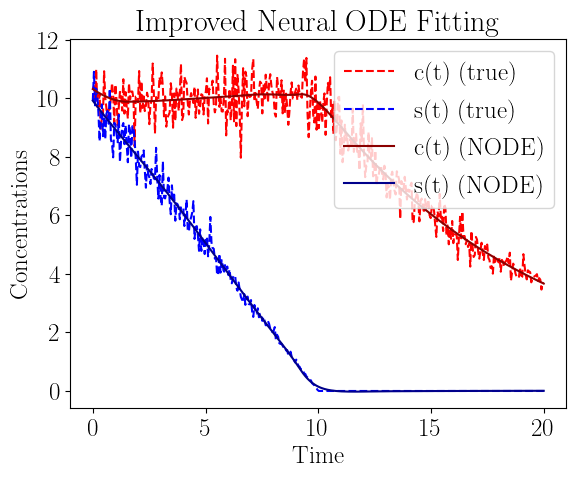

In [48]:
# Plot the results
plt.plot(t, data[:,0], color='red', linestyle='--', label='c(t) (true)')
plt.plot(t, data[:, 1],color='blue', linestyle='--', label='s(t) (true)')
plt.plot(t, y_pred[:, 0], color='darkred', linestyle='-', label='c(t) (NODE)')
plt.plot(t, y_pred[:, 1], color='darkblue', linestyle='-', label='s(t) (NODE)')
plt.xlabel('Time')
plt.ylabel('Concentrations')
plt.legend()
# plt.yscale('log')
plt.title('Improved Neural ODE Fitting')
plt.show()


In [49]:
# Assign the values to be used for the Jacobian matrix calculation
if NODE:
    x = y_pred.copy()
    fx = derivs.copy()

## Extrapolate predicted solution

In [50]:
extrapolate = True
if extrapolate:
    from NODE_module import ODEFunc, extrapolate_trajectory, compute_derivatives
    # Extrapolate trajectory
    t_extrap, y_extrap = extrapolate_trajectory(node_model, x[0], t0=t0, tf=tf, points=2000)
    
    # Compute derivatives along the extrapolated trajectory
    derivs_extrap = compute_derivatives(node_model, y_extrap)  # shape: (points, nspec)

    # t = t_extrap.copy()
    x = y_extrap.copy()
    fx = derivs_extrap.copy()
else:
    t_extrap = t

Extrapolating trajectory: 100%|███████████████████████████████████████████ 00:04


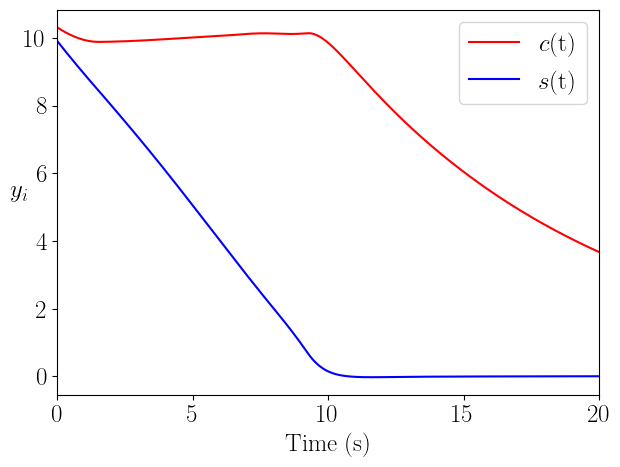

In [51]:
if extrapolate:
    if plot_solution: model.plot_solution(t_extrap, [0,x[:,0],x[:,1]], nspec, figs, figs_format, vars, time_unit,
                                      xlim=[t0,tf], ylim=[None,None],log=False, interactive=False)


# ANN Jacobian Estimation

In [52]:
normalized = True

# Jacobian estimation using ANN
if ANN: 
    from jhat_module import Jhat, Normalizer
    jhat_model = Jhat(domdim=nspec, codomdim=nspec, layers=[600, 600, 300, 150], batch_size = 64, epochs=150, learning_rate=0.0001, verbose=True)

    if normalized:
        normalizer = Normalizer()
        normalizer.fit(x, fx)
        x, fx = normalizer.transform(x, fx)
    
    jhat_model.fit(x, fx)    # Train the model

    jacobian_estimate = jhat_model.predict(x)
    if normalized:
        jacobian_estimate = normalizer.inverse_transform_jacobian(jacobian_estimate)


Preparing data from sample
Input shape (2000, 2)
Output shape (2000, 2)
Minimal distance: 0.0
Average distance: 0.002938857047423037
Maximal distance: 0.011684713828682537
Number of training data points: 6016
Finalized batch size: 64


Jhat Training: 100%|████████| 150/150 [01:54<00:00,  1.31epoch/s, loss=5.21e-02]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# CSP using the estimated Jacobian

In [53]:
tqdm._instances.clear()
(timescales_estimate, exp_timescales_estimate, amplitudes_estimate, Pointer_estimate) = csp.data_diagn_parallel(
    nspec, jacobian_estimate, fx, API_changed_sign=True, n_jobs=-1)

♾️ CSP analysis:   0%|░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 00:00

  0%|          | 0/2000 [00:00<?, ?it/s]

## CSP diagnostics plots

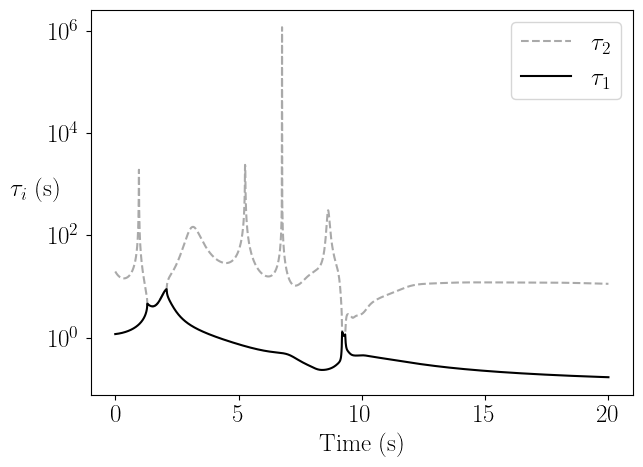

In [54]:
if plot_timescales: csp.plot_timescales(t_extrap, timescales_estimate, None, nspec, 'figs_estimated', figs_format, time_unit, 
                                        xlim=[None,None], ylim=[None,None], nfast=1, log=False, interactive=False);

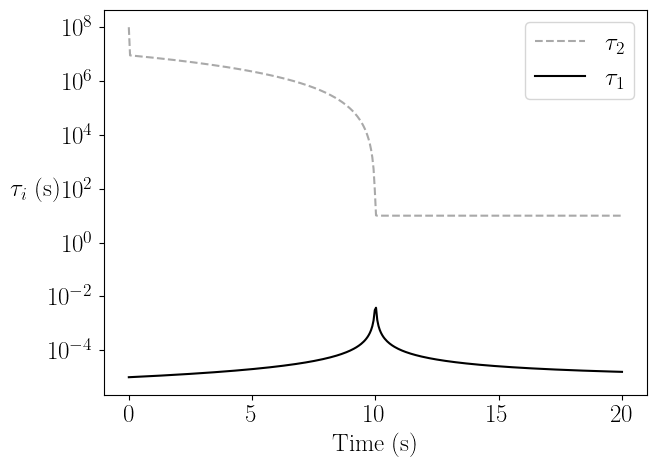

In [55]:
if plot_timescales: csp.plot_timescales(t, timescales, exp_timescales, nspec, figs, figs_format, time_unit, 
                                        xlim=[None,None], ylim=[None,None], nfast=1, log=False, interactive=false);

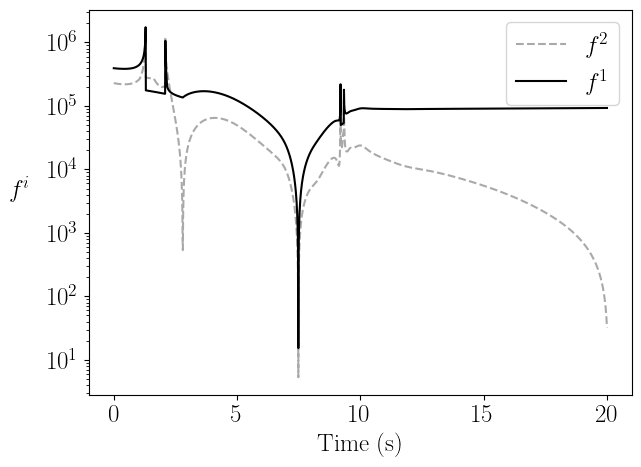

In [56]:
if plot_amplitudes: csp.plot_amplitudes(t_extrap, amplitudes_estimate, nspec, 'figs_estimated', figs_format, time_unit,
                                        xlim=[None,None], ylim=[None,None], nfast=1, interactive=False);

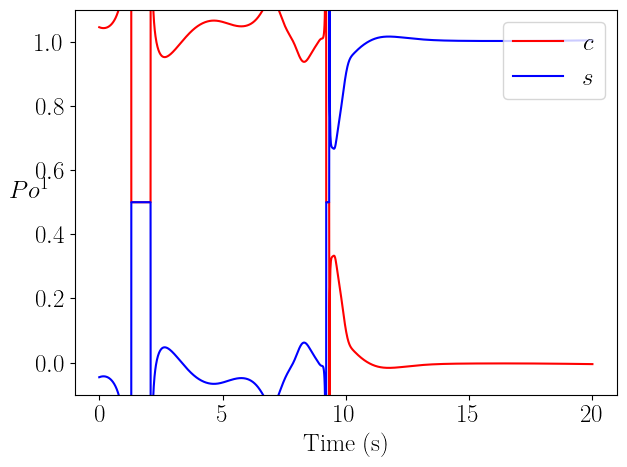

In [57]:
if plot_Po: csp.plot_Po(t_extrap, Pointer_estimate, nspec, vars, 'figs_estimated', figs_format, time_unit, 
                        xlim=[None,None], ylim=[-0.1,1.1], mode=1, interactive=False)

# SINDy on subsets from NODE Dataset

## 1$^\text{st}$ subset (Region of sQSSA)

In [66]:
import WeakSINDy_module as sindy
np.random.seed(42)
    
tsplit = 8 # in seconds
idx = np.argmin(np.abs(t - tsplit))

t_sim1 = t[:idx].copy()
x_sim1=data[:idx].copy()
thresholds = [0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_1nd = sindy.run_weak_sindy(t_sim1, x_sim1, noise, thresholds=thresholds, vars=vars)
    
# results_1st = sindy.run_weak_sindy(t_sim1, x_sim1, noise, thresholds=thresholds, vars=vars)

Threshold = 0.001
Dynamic model:
(c)' = 0.773 c + -0.727 s + -0.068 c^2 + 0.020 s^2 + 0.045 cs
(s)' = 2.448 c + -4.965 s + -0.237 c^2 + 0.059 s^2 + 0.432 cs
R²(c) score: 0.00850
R²(s) score: 0.06570

Threshold = 0.01
Dynamic model:
(c)' = 0.072 c + 0.015 s^2 + -0.020 cs
(s)' = 2.448 c + -4.965 s + -0.237 c^2 + 0.059 s^2 + 0.432 cs
R²(c) score: 0.00671
R²(s) score: 0.06570

Threshold = 0.02
Dynamic model:
(c)' = 0.031 c + 0.604 s + -0.064 cs
(s)' = -0.027 c + -0.980 s + 0.033 s^2 + 0.065 cs
R²(c) score: 0.00527
R²(s) score: 0.05049

Threshold = 0.03
Dynamic model:
(c)' = 0.031 c + 0.604 s + -0.064 cs
(s)' = -1.032 s + 0.041 s^2 + 0.061 cs
R²(c) score: 0.00527
R²(s) score: 0.04885

Threshold = 0.04
Dynamic model:
(c)' = 0.010 c
(s)' = -0.121 c + 0.049 s
R²(c) score: -0.00001
R²(s) score: 0.02017

Threshold = 0.05
Dynamic model:
(c)' = 0.000
(s)' = -0.091 c
R²(c) score: -0.01011
R²(s) score: 0.00151

Threshold = 0.06
Dynamic model:
(c)' = 0.000
(s)' = -0.091 c
R²(c) score: -0.01011
R²(s) 

## 2$^\text{nd}$ subset (Region of rQSSA)

In [64]:
import WeakSINDy_module as sindy
np.random.seed(42)

tsplit = 11 # in seconds
idx = np.argmin(np.abs(t - tsplit))
# idx = 250

t_sim2 = t[idx:].copy()
x_sim2=data[idx:].copy()
thresholds = [0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_2nd = sindy.run_weak_sindy(t_sim2, x_sim2, noise, thresholds, vars=vars)

Threshold = 0.001
Dynamic model:
(c)' = -0.105 c + 0.001 c^2
(s)' = 0.000
R²(c) score: 0.06026
R²(s) score: -0.63213

Threshold = 0.01
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.02
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.03
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.04
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.05
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.06
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.07
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.08
Dynamic model:
(c)' = -0.102 c
(s)' = 0.000
R²(c) score: 0.06021
R²(s) score: -0.63213

Threshold = 0.09
Dynamic model:
(c)' = -0.

In [67]:
! open .